In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
warnings.filterwarnings("ignore")

In [3]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#add experience
country_experience = PPP_data.groupby(['countrycode', 'IY']).size().reset_index().sort_values(['countrycode', 'IY'])
country_experience.columns = ['countrycode', 'IY', 'experience']
unique_country = country_experience.countrycode.unique()
years = np.arange(1990, 2020)

for country in unique_country:
    for year in years:
        if year not in country_experience.loc[country_experience.countrycode==country, 'IY'].values:
            country_experience = country_experience.append({'countrycode': country, 'IY': year, 'experience': 0}, ignore_index=True)

In [4]:
country_experience = country_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_experience.shape[0]))
country_experience['cum_experience'] = country_experience.groupby('countrycode')['experience'].cumsum()
country_experience.drop(columns=['experience'], inplace=True)

country_experience['shifted_country_experience_1'] = country_experience.groupby('countrycode')['cum_experience'].shift(1).fillna(method='bfill')
country_experience.drop(columns=['cum_experience'], inplace=True)

country_sector_experience = PPP_data.groupby(['countrycode', 'IY', 'sector']).size().reset_index().sort_values(['countrycode', 'IY'])
country_sector_experience.columns = ['countrycode', 'IY', 'sector', 'sector_experience']
unique_sector_country = country_sector_experience.countrycode.unique()
unique_sector = country_sector_experience.sector.unique()
years = np.arange(1990, 2020)

for country in unique_sector_country:
    for year in years:
        if year not in country_sector_experience.loc[country_sector_experience.countrycode==country, 'IY'].values:
            for sectors in unique_sector:
                country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                              'IY': year, 
                                                                              'sector': sectors, 
                                                                              'sector_experience': 0}, ignore_index=True)
        else:
            for sectors in unique_sector:
                if sectors not in country_sector_experience.loc[(country_sector_experience.countrycode==country) & (country_sector_experience.IY==year),
                                                                'sector'].values:
                    country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                                  'IY': year, 
                                                                                  'sector': sectors, 
                                                                                  'sector_experience': 0}, ignore_index=True)

country_sector_experience = country_sector_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_sector_experience.shape[0]))
country_sector_experience['cum_sector_experience'] = country_sector_experience.groupby(['countrycode', 'sector'])['sector_experience'].cumsum()
country_sector_experience.drop(columns=['sector_experience'], inplace=True)

country_sector_experience['shifted_sector_experience_1'] = country_sector_experience.groupby(['countrycode', 'sector'])['cum_sector_experience'].shift(1).fillna(method='bfill')
country_sector_experience.drop(columns=['cum_sector_experience'], inplace=True)

In [5]:
PPP_data = PPP_data.merge(country_experience,
                          left_on=['countrycode', 'IY'],
                          right_on=['countrycode', 'IY'],
                          how='left')

In [6]:
PPP_data.loc[:, 'PCO'] = PPP_data['PCO'].str.replace('\n', '') 
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'sponsor_number'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[2])
PPP_data.sponsor_number = PPP_data.sponsor_number.replace('', np.nan)

PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])

PPP_data.foreign_country = PPP_data.foreign_country.replace('N', 'No')
PPP_data.loc[(PPP_data.foreign_country!='No') & (~PPP_data.foreign_country.isnull()), 'foreign_country'] = 'Yes'

PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'sector'],
                          right_on=['countrycode', 'IY', 'sector'],
                          how='left')

In [7]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)   
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)
    dataset[i][name] = dataset[i].groupby('countrycode')[name].shift(1).fillna(method='bfill')

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [8]:
#copy data out.
data = PPP_data.copy()
data.drop(columns=['country',
                   'regionname',                   
                   'region',
                   'adminregionname',
                   'Description',
                   'FCY',
                   'bid_crit',
                   'incomelevelname',
                   'lendingtypename',
                   'TIGS',
                   'PCO',
                   'shareborder',
                   'GDP',
                   'population',
                   'investment_real',
                   'realphysicalassets',
                   'income'], inplace=True)

data.replace('..', np.nan, inplace=True)

data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability',
               'shifted_country_experience_1',
               'period',
               'CPI2019',
               'bordercountries', 
               'private', 
               'physical', 
               'period',
               'investment', 
               'pcapacity',
               'sponsor_number',
               'IY']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector'
                 'ssector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'BS',
                 'lendingtype'
                 'adminregion',
                 'foreign_country']
ordinal_value = ['incomelevel']

for float_column in float_value:
    data[float_column] = data[float_column].astype(float)

In [9]:
# BS (Bilateral Support) replace with NO and Yes, 
data.loc[(data.BS!='No') & (~data.BS.isnull()), 'BS'] = 'Yes'
#private convert to categorical data.
#physical, investment, pcapacity will be converted to np.log
to_log = ['physical', 'investment', 'pcapacity']
for column in to_log:
    data[column] = np.log(data[column] + 0.01)

In [10]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [11]:
def fillna_nominal(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame().reset_index()
    # if no mode for current group, then fill with the mode in current column.
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test
def fillna_numerical(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mean_in_train = train.groupby(group_list)[column].mean().to_frame().reset_index()
    for i, rows in mean_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

In [271]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5322 entries, 851 to 4383
Data columns (total 44 columns):
IY                              5322 non-null float64
Region                          5322 non-null object
IDA                             5322 non-null object
type                            5322 non-null object
stype                           5322 non-null object
sector                          5322 non-null object
ssector                         5322 non-null object
Segment                         5322 non-null object
period                          3858 non-null float64
GGC                             4272 non-null object
private                         5121 non-null float64
physical                        5087 non-null float64
investment                      4932 non-null float64
pcapacity                       4566 non-null float64
PRS                             5318 non-null object
BS                              5127 non-null object
UP                              5322 

In [12]:
missing_categorical = {'lendingtype': ['countrycode', 'ssector'],
                       'GGC': ['countrycode', 'ssector'],
                       'PRS': ['countrycode', 'ssector'],
                       'BS': ['countrycode', 'ssector'],
                       'adminregion': ['Region'],
                       'incomelevel': ['Region'],
                       'foreign_country': ['countrycode', 'ssector']}

for column, group_list in missing_categorical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_nominal(X_train, X_test, group_list, column)

missing_numerical = {'period': ['stype', 'sector', 'Region', 'countrycode'],
                     'pcapacity': ['stype', 'sector', 'Region', 'countrycode'],
                     'private': ['stype', 'ssector', 'countrycode'],
                     'physical': ['stype', 'ssector', 'countrycode'],
                     'investment': ['stype', 'ssector', 'countrycode'],
                     'tax_as_GDP': ['Region'],
                     'real_effective_change': ['Region'],
                     'domestic_credit_to_private': ['Region'],
                     'rule_of_law': ['Region'],
                     'imports_as_GDP': ['Region'],
                     'exports_as_GDP': ['Region'],
                     'electric_consumption': ['Region'],
                     'sponsor_number': ['countrycode', 'ssector']}

for column, group_list in missing_numerical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_numerical(X_train, X_test, group_list, column)

In [13]:
X_train.drop(columns=['countrycode'], inplace=True)
X_test.drop(columns=['countrycode'], inplace=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [14]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object], drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]
#scaling data
scaler = RobustScaler()
numeric_column = X_train.columns[X_train.dtypes == 'float64']
X_train[numeric_column] = scaler.fit_transform(X_train[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])

In [15]:
X_bal, y_bal = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

X_bal = pd.DataFrame(X_bal, columns=X_train.columns)
y_bal = pd.DataFrame(y_bal, columns=['status_n'])
# ###########
balanced = X_bal.join(y_bal)
bal_corr = balanced.corr()

In [16]:
data_dict = {}
for threshold in [0]:
    for out in [6]:
        no_outliers = pd.DataFrame(balanced.copy())
        cols = bal_corr.status_n.index[:-1]
        for col in cols:
            correlation = bal_corr.loc['status_n', col]
            if np.abs(correlation) > threshold:
                nonfrauds = no_outliers.loc[no_outliers.status_n==0, col]
                frauds = no_outliers.loc[no_outliers.status_n==1, col]
        
                all_values = no_outliers.loc[:,col]
                q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
                iqr = q75 - q25
                cutoff = iqr * out
                lower, upper = q25 - cutoff, q75 + cutoff
                if correlation > 0: 
                    no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
                    no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
                elif correlation < 0: 
                    no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
                    no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)        
        for i in [0.02]:
            data_list = []
            key =(threshold, out, i)
            feat_sel =pd.DataFrame(no_outliers.copy())
            new_corr = feat_sel.corr()
            for col in new_corr.status_n.index[:-1]:
                if np.abs(new_corr.loc['status_n', col]) < i:
                    feat_sel.drop(columns=col, inplace=True)

            X_final_train = feat_sel.drop('status_n', 1)
            y_final_train = feat_sel.status_n

            X_final_test = X_test[X_final_train.columns]
            y_final_test = y_test
            data_list.append([X_final_train, y_final_train, X_final_test, y_final_test])
            data_dict[key] = data_list

In [355]:
len(data_dict)

120

In [313]:
X_final_train.shape

(10230, 63)

In [84]:
X_final_train, y_final_train = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
    X_final_train,
    y_final_train)

In [85]:
X_final_train.shape

(8302, 47)

In [26]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

def plot_recall_precision(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    plt.title('Recall-Precision')
    plt.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.legend(loc = 'lower right')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')

def plot_cm(labels, predictions, p=0.1):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def plot_threshold_graph(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score = 2*precision*recall/(recall + precision)
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision, 'k')
    plt.plot(thresholds, recall,'r')
    plt.plot(thresholds, f1_score, 'y')

In [18]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 25)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 30)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 20)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 30, 20)],
              'bootstrap': [True, False]}
clf_random_grid = RandomizedSearchCV(clf,
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1,
                                     random_state=123)
random_forest_result = []
for k,v in data_dict.items():
    clf_random_grid.fit(v[0][0], v[0][1])
    pred_clf_upsample = cross_val_predict(clf_random_grid.best_estimator_,
                                          v[0][2],
                                          v[0][3],                                      
                                          method='predict_proba',
                                          cv=5)
    random_forest_result.append(pred_clf_upsample)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   18.0s finished


In [20]:
result_2 = random_forest_result.copy()

In [21]:
len(result_2)

1

In [302]:
clf_random_grid.best_params_

{'n_estimators': 1551,
 'min_samples_split': 19,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 46,
 'bootstrap': False}

In [22]:
plot_threshold_graph(y_test, result[0][:,1])

NameError: name 'result' is not defined

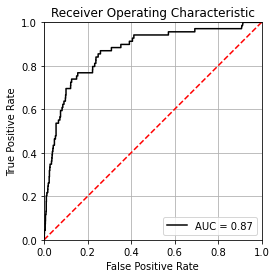

In [23]:
for i in result_2:
    plot_roc(y_test, i[:,1])

No handles with labels found to put in legend.


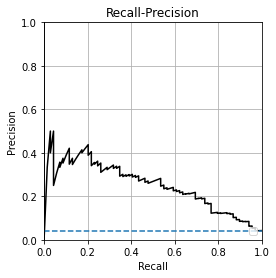

In [24]:
for i in result_2:
    plot_recall_precision(y_test, i[:,1])

In [30]:
confusion_matrix(y_test, result_2[0][:, 1] > 0.103)

array([[1538,  167],
       [  24,   45]], dtype=int64)

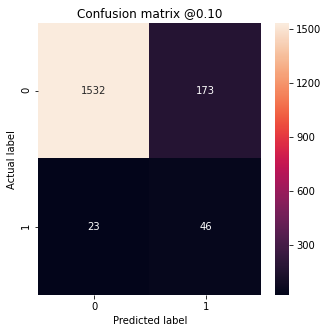

In [320]:
plot_cm(y_test, pred_clf_upsample[:, 1])

In [286]:
#feature importance
fi = pd.DataFrame({'feature': list(X_bal.columns),
                   'importance': clf_random_grid.best_estimator_.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [288]:
fi.head(50)

,feature,importance
8,CPI2019,0.100444
0,IY,0.090410
94,PRS_Purchase Agreements (private & public),0.054230
33,type_Greenfield project,0.040714
9,shifted_country_experience_1,0.037596
14,life_expectnacy,0.036318
108,Renewables_Renewables,0.034191
16,electric_consumption,0.031265
10,sponsor_number,0.028707
25,voice_and_accountability,0.025197


In [289]:
X_train_lgb = X_bal.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_lgb = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train_lgb = y_bal.copy()
y_test_lgb = y_test.copy()
clf_lgb = lgb.LGBMClassifier(random_state=1)

param_grid = {'learning_rate': [x for x in np.linspace(0.005, 0.01, 3)],
              'n_estimators': [int(x) for x in np.linspace(700, 2000, 30)],
              'num_leaves': [int(x) for x in np.linspace(10, 40, 30)],
              'boosting_type' : ['gbdt'],
              'objective' : ['binary'],
              'random_state' : [501], 
              'colsample_bytree' : [x for x in np.linspace(0.1, 1.0, 30)],
              'subsample' : [x for x in np.linspace(0.1, 1.0, 30)]}
lgb_random_grid = RandomizedSearchCV(clf_lgb,                                     
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1,
                                     random_state=123)
lgb_random_grid.fit(X_train_lgb, y_train_lgb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   41.1s finished


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.1,
                                                             0.1310344827586207,
                                                             0.16206896551724137,
                                                             0.19310344827586207,
                                                             0.22413793103448276,
                                                             0.25517241379310346,
                                                             0.28620689655172415,
                                                             0.3172413793103448,
                                                             0.34827586206896555,
                                                             0.3793103448275862,
                                                      

In [290]:
lgb_random_grid.best_params_

{'subsample': 0.41034482758620694,
 'random_state': 501,
 'objective': 'binary',
 'num_leaves': 38,
 'n_estimators': 2000,
 'learning_rate': 0.0075,
 'colsample_bytree': 0.5655172413793104,
 'boosting_type': 'gbdt'}

In [291]:
pred_lgb_upsample = cross_val_predict(lgb_random_grid.best_estimator_,
                                      X_test_lgb,
                                      y_test_lgb,
                                      method='predict_proba',
                                      cv=5)

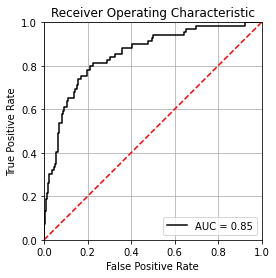

In [292]:
plot_roc(y_test, pred_lgb_upsample[:,1])

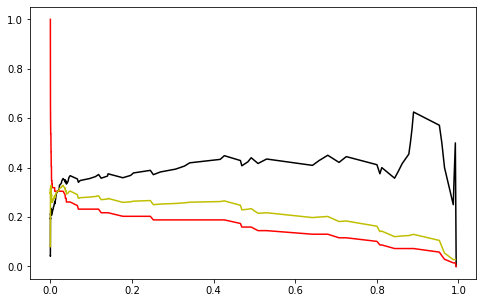

In [293]:
plot_threshold_graph(y_test, pred_lgb_upsample[:,1])

No handles with labels found to put in legend.


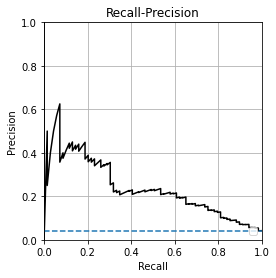

In [294]:
plot_recall_precision(y_test_lgb, pred_lgb_upsample[:,1])

In [297]:
confusion_matrix(y_test, pred_lgb_upsample[:, 1] > 0.01)

array([[1641,   64],
       [  47,   22]], dtype=int64)

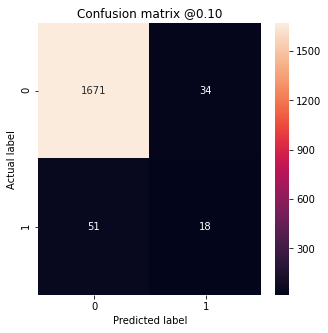

In [127]:
plot_cm(y_test_lgb, pred_lgb_upsample[:, 1])